#Paquetes necesarios

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

## Tarea 1 - Captura una o varias imágenes con monedas no solapadas. 

Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

**Nota:** Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

**Extras:** Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

1
2
5
1
50
20
1
1
1
1
1
1
1
20
1
1
1
1
1
1
20
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
5
5
10
5
2
20
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
5
1
1
200
50
100
1
Tienes  5.85 €


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


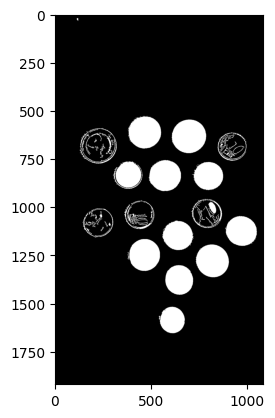

In [64]:
img = cv2.imread('Material P3/Monedas.jpg')
img = cv2.imread('Images/Coins1.jpeg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th,img_th = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
img_th = cv2.adaptiveThreshold(img_gris,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,11,2)
#Obtiene únicamente los contornos externos
contornos, hierarchy = cv2.findContours(img_th, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

coin_sizes = {1: 16.26,
              2: 18.75,
              5: 21.25,
              10: 19.75,
              20: 22.25,
              50: 24.25,
              100: 23.25,
              200: 25.75}
# Pide el valor de la moneda a seleccionar al usuario
reference_diameter = coin_sizes[int(input("Seleccione el valor de la moneda de referencia (en centimos)"))]
coin_ratios = {int(round(16.26/reference_diameter,2)*100) : 1, 
               int(round(18.75/reference_diameter,2)*100): 2, 
               int(round(21.25/reference_diameter,2)*100): 5, 
               int(round(19.75/reference_diameter,2)*100): 10, 
               int(round(22.25/reference_diameter,2)*100): 20,
               int(round(24.25/reference_diameter,2)*100): 50,
               int(round(23.25/reference_diameter,2)*100): 100,
               int(round(25.75/reference_diameter,2)*100): 200}

# Pide que el usuario seleccione una moneda
ix = None
iy = None
clicked = False
def select_point(event,x,y,flags,param):
    global ix,iy,clicked
    if event == cv2.EVENT_LBUTTONDOWN: # captures left button double-click
        ix,iy = x,y
        clicked=True

cv2.imshow('Select reference coin',img)
cv2.setMouseCallback('Select reference coin', select_point)
while cv2.waitKey(20) != 27:
        if clicked:
             break
cv2.destroyAllWindows()


experimental_diameters = []
experimental_reference = None
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 50:
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        experimental_diameters.append(radio * 2)
        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
        if np.sqrt(np.power(ix-cx,2) + np.power(iy-cy, 2)) <= radio:
             experimental_reference = radio * 2

             
new_ratios = [element / experimental_reference for element in experimental_diameters]
money = 0
for ratio in new_ratios:
    money += coin_ratios[list(coin_ratios.keys())[np.argmin([abs(element - int(round(ratio,3)*100)) for element in coin_ratios.keys()])]]
    print(coin_ratios[list(coin_ratios.keys())[np.argmin([abs(element - int(round(ratio,3)*100)) for element in coin_ratios.keys()])]])
print("Tienes ", money/100, "€")
plt.imshow(img_cont) 

El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV.

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

## Análisis de la imagen

In [5]:
def find_countour_characteristics_test(img):
    # Localiza contornos
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th,img_th = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    characteristics = []
    # Process each contour to calculate compactness and ellipse ratio (if possible)
    for c in contours:
        # Puntos del contorno
        clon = len(c)

        # Área y perímetro
        area = cv2.contourArea(c)
        if area < 300:
            continue
        perimetro = cv2.arcLength(c, True)
        
        # Color del microplástico
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, c, -1, 255, -1)
        color = cv2.mean(img, mask=mask)

        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(img, (x,y), (x+w,y+h),255,2)
        
        # Compactness: 4*pi*Area/Perimeter^2
        if perimetro > 0:
            compacidad = (perimetro ** 2) / area
        else:
            compacidad = 0
        char = {"N puntos": clon, "Area": area, "Perimetro": perimetro, "Compact": compacidad, "Color": color[0]}        
        characteristics.append(char)
        
    # Visualiza la imagen
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    plt.title("Formas")
    plt.axis('off')
    plt.show()
    return characteristics

## Análisis de la imagen con Fragmentos 

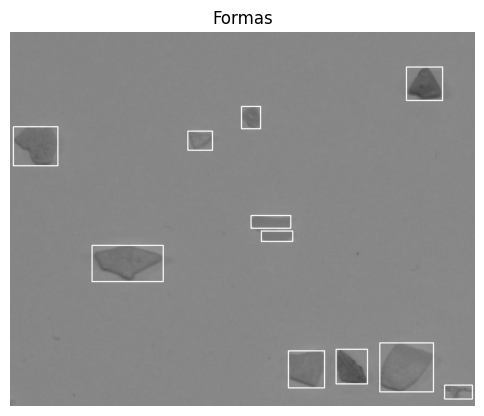

[{'N puntos': 117,
  'Area': 835.5,
  'Perimetro': 220.7523068189621,
  'Compact': 58.326248911900876,
  'Color': 120.1965811965812},
 {'N puntos': 178,
  'Area': 6134.5,
  'Perimetro': 347.66399443149567,
  'Compact': 19.70335854985134,
  'Color': 120.32203389830508},
 {'N puntos': 137,
  'Area': 4342.5,
  'Perimetro': 292.3502857685089,
  'Compact': 19.68190894390992,
  'Color': 118.33576642335765},
 {'N puntos': 587,
  'Area': 6345.5,
  'Perimetro': 1008.8153566122055,
  'Compact': 160.38270013972286,
  'Color': 121.08231173380035},
 {'N puntos': 228,
  'Area': 9415.0,
  'Perimetro': 466.1320300102234,
  'Compact': 23.077968072379374,
  'Color': 119.77631578947367},
 {'N puntos': 143,
  'Area': 1146.0,
  'Perimetro': 263.7644993066788,
  'Compact': 60.70829938438302,
  'Color': 121.5},
 {'N puntos': 170,
  'Area': 1667.0,
  'Perimetro': 306.39191603660583,
  'Compact': 56.31434085937764,
  'Color': 121.25301204819277},
 {'N puntos': 155,
  'Area': 645.5,
  'Perimetro': 272.007139801

In [6]:
img = cv2.imread('Material P3/FRA.png')
find_countour_characteristics_test(img)

## Análisis de la Imagen con Pellets

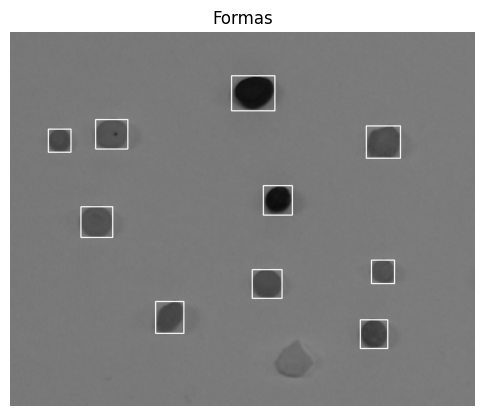

[{'N puntos': 120,
  'Area': 3761.0,
  'Perimetro': 239.62236404418945,
  'Compact': 15.266917668206876,
  'Color': 89.71666666666667},
 {'N puntos': 114,
  'Area': 3934.0,
  'Perimetro': 250.93607211112976,
  'Compact': 16.006332558861747,
  'Color': 90.03508771929825},
 {'N puntos': 109,
  'Area': 4136.5,
  'Perimetro': 247.0365777015686,
  'Compact': 14.753310944639948,
  'Color': 90.33944954128441},
 {'N puntos': 101,
  'Area': 2544.0,
  'Perimetro': 203.33809304237366,
  'Compact': 16.25250789391077,
  'Color': 90.70297029702971},
 {'N puntos': 125,
  'Area': 4740.0,
  'Perimetro': 267.7644991874695,
  'Compact': 15.126123844961255,
  'Color': 90.904},
 {'N puntos': 127,
  'Area': 4046.0,
  'Perimetro': 247.1370825767517,
  'Compact': 15.095585166719772,
  'Color': 89.99212598425197},
 {'N puntos': 102,
  'Area': 2492.5,
  'Perimetro': 195.58073341846466,
  'Compact': 15.346769622669827,
  'Color': 90.44117647058823},
 {'N puntos': 111,
  'Area': 5302.5,
  'Perimetro': 289.0365771

In [7]:
img = cv2.imread('Material P3/PEL.png')
find_countour_characteristics_test(img)

## Análisis de la Imagen con Alquitrán

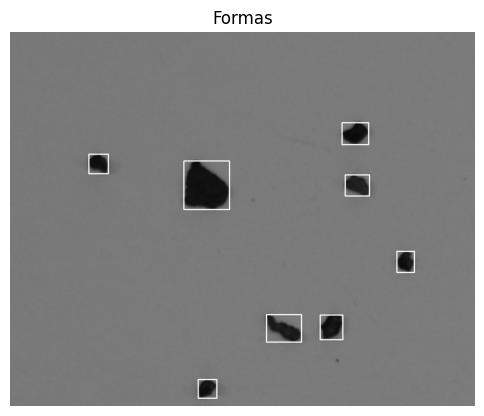

[{'N puntos': 65,
  'Area': 1442.0,
  'Perimetro': 150.02438533306122,
  'Compact': 15.608402354065765,
  'Color': 67.33846153846154},
 {'N puntos': 90,
  'Area': 2421.5,
  'Perimetro': 197.92387974262238,
  'Compact': 16.177518964431982,
  'Color': 66.83333333333334},
 {'N puntos': 134,
  'Area': 2794.5,
  'Perimetro': 261.5218594074249,
  'Compact': 24.47439003324993,
  'Color': 68.41044776119404},
 {'N puntos': 79,
  'Area': 1507.0,
  'Perimetro': 158.50966608524323,
  'Compact': 16.67240493859012,
  'Color': 68.0},
 {'N puntos': 87,
  'Area': 2090.5,
  'Perimetro': 185.92387926578522,
  'Compact': 16.535608170886523,
  'Color': 68.02298850574712},
 {'N puntos': 187,
  'Area': 9690.0,
  'Perimetro': 408.47517585754395,
  'Compact': 17.218985479035236,
  'Color': 67.7379679144385},
 {'N puntos': 66,
  'Area': 1653.0,
  'Perimetro': 161.19595801830292,
  'Compact': 15.7193810535018,
  'Color': 68.57575757575758},
 {'N puntos': 83,
  'Area': 2317.0,
  'Perimetro': 193.96550941467285,
 

In [8]:
img = cv2.imread('Material P3/TAR.png')
find_countour_characteristics_test(img)

In [9]:
def find_countour_characteristics(img):
    # Localiza contornos
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th,img_th = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    characteristics = []
    # Process each contour to calculate compactness and ellipse ratio (if possible)
    for c in contours:
        # Puntos del contorno
        clon = len(c)

        # Área y perímetro
        area = cv2.contourArea(c)
        if area < 300:
            continue
        perimetro = cv2.arcLength(c, True)

        # Color del microplástico
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, c, -1, 255, -1)
        color = cv2.mean(img, mask=mask)



        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(img, (x,y), (x+w,y+h),255,2)
        
        # Compactness: 4*pi*Area/Perimeter^2
        if perimetro > 0:
            compacidad = (perimetro ** 2) / area
        else:
            compacidad = 0
        
        # Muestra valores en imageb
        char = {"N puntos": clon, "Area": area, "Perimetro": perimetro, "Compact": compacidad, "Color": color[0]}
        characteristics.append(char)
    return characteristics


def classify(label, img):
    img = cv2.imread(img)
    characteristics = find_countour_characteristics(img)
    y = []
    y_pred = []
    for char in characteristics:
        y.append(label)
        if char["Compact"] > 30 and char["N puntos"] > 100:
            predicted_label = "fra"
        elif char["Color"] > 110:
            predicted_label = "fra"
        elif char["Color"] < 70:
            predicted_label = "tar"
        else:
            predicted_label = "pellet"
        y_pred.append(predicted_label)
    return y, y_pred


¿Cómo de bien encajan anotación y predicción?
Accuracy (TP/(n))= 0.9521276595744681
Precision (TP/(TP+FP)) = 0.9571964956195244
Recall (TP/(TP+FN)) = 0.9521276595744681
F1 Score (2*(precision*recall)/(precision+recall)) = 0.9514140346240254


Text(38.25, 0.5, 'Real/Anotado')

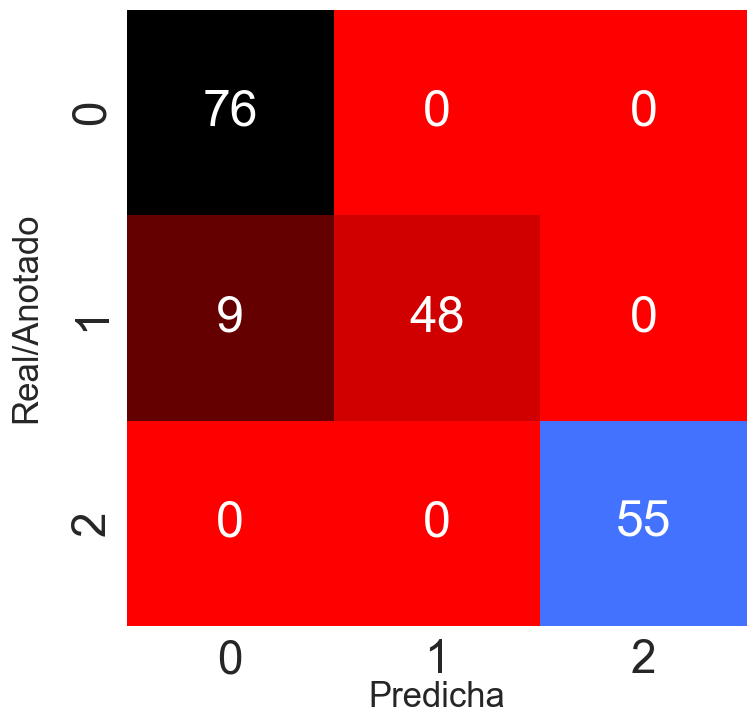

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

y = []
y_pred = []
images = {"Material P3/tar-03-olympus-10-01-2020.JPG" : "tar",
            "Material P3/pellet-03-olympus-10-01-2020.JPG": "pellet",
            "Material P3/fragment-03-olympus-10-01-2020.JPG": "fra"}
for image in images.keys():
    y_new, y_pred_new = classify(images[image], image)
    y.extend(y_new)
    y_pred.extend(y_pred_new)


print('¿Cómo de bien encajan anotación y predicción?')

#Cálculo de métricas
accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)

## Predicción en un caso real

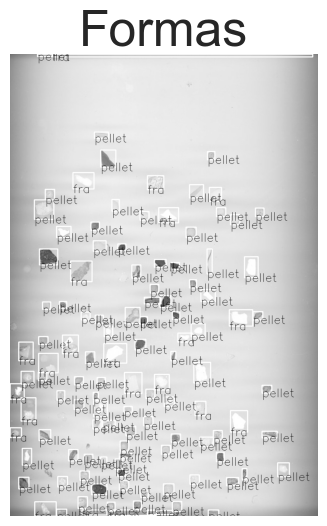

In [17]:
def classify_char(char):
    if char["Compact"] > 30 and char["N puntos"] > 100:
        return "fra"
    elif char["Color"] > 110:
        return "fra"
    elif char["Color"] < 70:
        return "tar"
    else:
        return "pellet"

def predict_label(img):
    # Localiza contornos
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_th = 255 - cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
    contours, _ = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Parámeros texto
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 1
    color = (255, 255, 255)
    # Process each contour to calculate compactness and ellipse ratio (if possible)
    for c in contours:
        # Puntos del contorno
        clon = len(c)

        # Área y perímetro
        area = cv2.contourArea(c)
        if area < 100:
            continue
        perimetro = cv2.arcLength(c, True)

        # Color del microplástico
        mask = np.zeros(img.shape, np.uint8)
        cv2.drawContours(mask, c, -1, 255, -1)
        color = cv2.mean(img, mask=mask)



        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(img, (x,y), (x+w,y+h),255,2)
        
        # Compactness: 4*pi*Area/Perimeter^2
        if perimetro > 0:
            compacidad = (perimetro ** 2) / area
        else:
            compacidad = 0
        
        # Muestra valores en imageb
        char = {"N puntos": clon, "Area": area, "Perimetro": perimetro, "Compact": compacidad, "Color": color[0]}
        cv2.putText(img, classify_char(char), (x, int(y+h+10)), font, font_scale, (0,0,0), thickness)
    # Visualiza la imagen
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
    plt.title("Formas")
    plt.axis('off')
    plt.show()


img = cv2.imread("Material P3/MPs.jpg")
predict_label(img)
